In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score, RocCurveDisplay, fbeta_score, accuracy_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression


import tensorflow as tf
from tensorflow.keras.utils import plot_model

import keras 
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout      # create layers
from keras.metrics import CategoricalAccuracy, Recall, Precision, AUC
from keras.backend import clear_session
from keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

import pickle

import os
import sys
sys.path.append("..")
from src.data.preprocessing import load_preprocess_data
from src.features.feature_engineering import create_features, unwrap_smart_7



# Read Data

In [2]:
# read data
repo_path = os.getcwd() + "/../"
df_source = load_preprocess_data(path=repo_path)
df = create_features(df_source, interval=30, trigger_percentage=0.05)
df = unwrap_smart_7(df)

  0%|          | 0/608 [00:00<?, ?it/s]../src/features/feature_engineering.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.smart_7_mod[temp_data.index] = temp_data.smart_7_raw
100%|██████████| 608/608 [00:13<00:00, 43.84it/s]


# Check Duplicates

In [3]:
serials_failed = df_source.query("failure == 1")["serial_number"].to_list()
serials_failed_unique = set(serials_failed)
print("Number of failed days:", len(serials_failed))
print("Number of unique serial number on the failed day:", len(serials_failed_unique))
tmp = serials_failed[:]
for serial in serials_failed_unique:
    tmp.remove(serial)

if len(tmp) == 0:
    print("There is no duplicate")
else:
    print(f"There {len(tmp)} duplicates")
    print("   duplicated serial numbers",tmp)
    df.drop(298155, inplace=True)
    df.drop(309081, inplace=True)
    df.reset_index(inplace=True)
    print("Number of rows before drop:", len(df_source))
    print("Number of rows after drop:", len(df))   

Number of failed days: 610
Number of unique serial number on the failed day: 608
There 2 duplicates
   duplicated serial numbers ['Z302SQFX', 'Z303VDR4']
Number of rows before drop: 462966
Number of rows after drop: 462964


# Create Target

In [4]:
# create target
df['failure_in_30_days'] = df['countdown'].apply(lambda x : 1 if x <= 30 else 0)
df.head(5)

,index,date,serial_number,model,failure,smart_1_raw,smart_4_raw,smart_5_raw,smart_7_raw,smart_9_raw,...,smart_187_raw_trigger,smart_188_raw_trigger,smart_189_raw_trigger,smart_193_raw_trigger,smart_192_raw_trigger,smart_197_raw_trigger,smart_198_raw_trigger,smart_199_raw_trigger,smart_999,failure_in_30_days
0,0,2020-09-18,Z304JG86,ST4000DM000,0,93783288.0,13.0,0.0,208544989.0,42390.0,...,False,False,False,False,False,False,False,False,0,0
1,1,2020-09-18,S301GMGZ,ST4000DM000,0,55185864.0,13.0,0.0,586510565.0,42857.0,...,True,False,False,False,False,True,True,False,3,0
2,2,2020-09-18,S300YQTN,ST4000DM000,0,170426904.0,6.0,0.0,639460780.0,46828.0,...,False,False,False,False,False,False,False,False,0,0
3,3,2020-09-18,Z302T8AB,ST4000DM000,0,119029336.0,27.0,0.0,615938251.0,44034.0,...,False,False,False,False,False,False,False,False,0,0
4,4,2020-09-18,Z302SXFH,ST4000DM000,0,18778216.0,8.0,0.0,587606218.0,44474.0,...,False,False,False,False,False,False,False,False,0,1


# Split Data

In [5]:
# split data
RSEED = 420
serial_train, serial_test, dummy1, dummy2 = train_test_split(df['serial_number'].unique(), df['serial_number'].unique(), test_size=0.3, random_state=RSEED)
df_train = df[df['serial_number'].isin(serial_train)]
df_test = df[df['serial_number'].isin(serial_test)]

print("number of unique disk in data:", df["serial_number"].nunique())
print("number of unique disk in train:", df_train["serial_number"].nunique())
print("number of unique disk in test:", df_test["serial_number"].nunique())

number of unique disk in data: 608
number of unique disk in train: 425
number of unique disk in test: 183


In [6]:
#df.columns

# Set X and y

In [7]:
# set X and y
cols_feature = [
    'smart_1_raw', 
    'smart_4_raw', 'smart_5_raw', 'smart_7_mod', 'smart_9_raw',
    'smart_12_raw', 'smart_183_raw', 'smart_184_raw', 'smart_187_raw',
    'smart_188_raw', 'smart_189_raw', 'smart_192_raw',
    'smart_193_raw', 'smart_197_raw', 'smart_198_raw',
    'smart_199_raw', 'smart_240_raw', 'smart_241_raw', 'smart_242_raw',
    'smart_999']
    # 190, 194 are temperature

X_train = df_train[cols_feature]
y_train = df_train['failure_in_30_days']

X_test = df_test[cols_feature]
y_test = df_test['failure_in_30_days']

# Log and Scale

In [8]:
# log 
X_train_log = X_train.apply(lambda x : np.log10(x+1))
X_test_log = X_test.apply(lambda x : np.log10(x+1))

# scale
scaler = MinMaxScaler()
scaler.fit(X_train_log)

X_train_log_scaled = pd.DataFrame(scaler.transform(X_train_log), columns=X_train_log.columns)
X_test_log_scaled = pd.DataFrame(scaler.transform(X_test_log), columns=X_test_log.columns)
#X_train_log_scaled.describe()

# Function for Printing Metrics

In [9]:
def show_metrics(y_train, y_train_pred, y_test, y_test_pred, digit=3):
    for data in ["train", "test"]:
        print("=======================================")
        print(f"# For {data} data:")
        if data == "train":
            y_true = y_train
            y_pred = y_train_pred
        else:
            y_true = y_test
            y_pred = y_test_pred
        f2 = fbeta_score(y_true, y_pred, beta=2)
        pre = precision_score(y_true, y_pred)
        rec = recall_score(y_true, y_pred)
        acc = accuracy_score(y_true, y_pred)
        print("  f2-score  :", (f2*100).round(digit), "%")
        print("  precision :", (pre*100).round(digit), "%")
        print("  recall    :", (rec*100).round(digit), "%")
        print("  accuracy  :", (acc*100).round(digit), "%")

    fig, axes = plt.subplots(2,2,figsize=(6, 6))
    fig.suptitle("Confusion Matrix")
    for i in range(4):
        if i//2 == 0:
            train_or_test = "Train"
            y_true = y_train
            y_pred = y_train_pred
        else:
            train_or_test = "Test"
            y_true = y_test
            y_pred = y_test_pred
        if i%2 == 0:
            scale = " (log scale)"
            data = np.log10(confusion_matrix(y_true, y_pred))
        else:
            data = confusion_matrix(y_true, y_pred)
            scale = ""
        sns.heatmap(data, annot=True, ax=axes[i//2, i%2])
        axes[i//2,i%2].set_title(f"{train_or_test}{scale}")
        axes[i//2,i%2].set_ylabel("Truth", fontsize=25)
        axes[i//2,i%2].set_xlabel("Prediction", fontsize=25)

    fig.tight_layout()
    plt.show()

def show_roc_curve(y_train, y_train_score, y_test, y_test_score):
    RocCurveDisplay.from_predictions(y_train, y_train_score)
    RocCurveDisplay.from_predictions(y_test, y_test_score)

def show_neural_network_loss(history):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Loss Function')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def show_threshold_tuning(y_true, y_pred_prob, digit=3):
    # precision, recall, and f2 at different thresholds
    pre, rec, thresholds = precision_recall_curve(y_true, y_pred_prob)
    f2 = (5)*(pre*rec)/(4*pre + rec)
    plt.plot(thresholds, pre[1:],'r-',label = 'Precision')
    plt.plot(thresholds, rec[1:],'b-',label = 'Recall')
    plt.plot(thresholds, f2[1:],'g-',label = 'f2')
    plt.legend()
    plt.xlabel('Threshold')
    plt.ylabel('Metrics')
    plt.show()

    # max f2
    print(f'Max f2: {(np.nanmax(f2)*100).round(digit)} %; Threshold: {thresholds[np.nanargmax(f2)]}')
    print(f'Recall: {(rec[np.nanargmax(f2)]*100).round(digit)} %')
    print(f'Precision: {(pre[np.nanargmax(f2)]*100).round(digit)} %')


# Neural Network

Construct layers and compile:

In [10]:
# clear session after repeated runs
clear_session()

# Initialising the NN
model = Sequential()

# layers
model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dropout(0.2))
#model.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
#model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
#model.add(Dropout(0.2))
model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


#optz = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
#optz = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
#optz = tf.keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999) # gives error during fit
#optz = tf.keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

# Compiling the ANN
#model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['AUC', 'Recall', 'Precision', 'accuracy'])
model.compile(optimizer = 'adam', 
              loss = 'binary_crossentropy', 
              metrics = ['Recall', 'Precision']
              )

#print(model.summary())
#plot_model(model, show_shapes=True, show_layer_names=True, dpi=96)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-28 09:28:47.949512: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 09:28:47.950477: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Train the network:

Epoch 1/50


2022-03-28 09:28:48.296322: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-28 09:28:48.941867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 - 2s - loss: 0.8633 - recall: 0.0959 - precision: 0.0293 - val_loss: 0.6877 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 2s/epoch - 224ms/step
Epoch 2/50


2022-03-28 09:28:49.797532: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 - 0s - loss: 0.8579 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6796 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 402ms/epoch - 57ms/step
Epoch 3/50
7/7 - 0s - loss: 0.8497 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6665 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 310ms/epoch - 44ms/step
Epoch 4/50
7/7 - 0s - loss: 0.8368 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6457 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 297ms/epoch - 42ms/step
Epoch 5/50
7/7 - 0s - loss: 0.8167 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6138 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 294ms/epoch - 42ms/step
Epoch 6/50
7/7 - 1s - loss: 0.7879 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5688 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - 521ms/epoch - 74ms/step
Epoch 7/50
7/7 - 1s - loss: 0.7506 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.5115 - val_recall: 0.0000e+

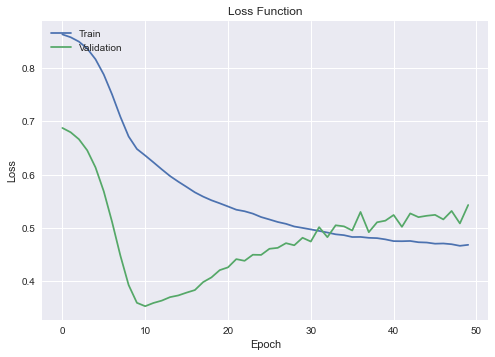

In [11]:
# Train the ANN
training = model.fit(X_train_log_scaled, y_train, batch_size = 40000, validation_split=0.2, epochs = 50, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)

# show loss
show_neural_network_loss(training.history)

2022-03-28 09:29:07.509117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# For train data:
  f2-score  : 41.198 %
  precision : 19.603 %
  recall    : 56.856 %
  accuracy  : 88.733 %
# For test data:
  f2-score  : 41.127 %
  precision : 22.338 %
  recall    : 52.077 %
  accuracy  : 90.719 %


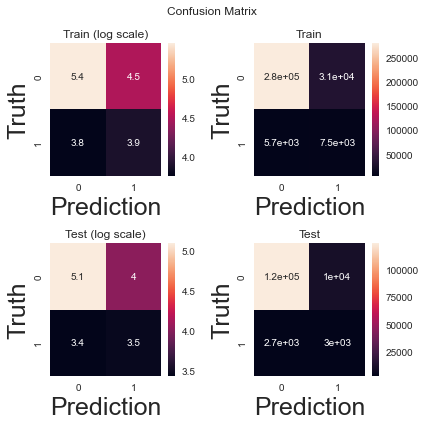

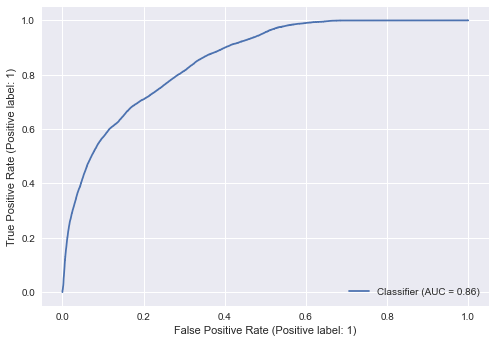

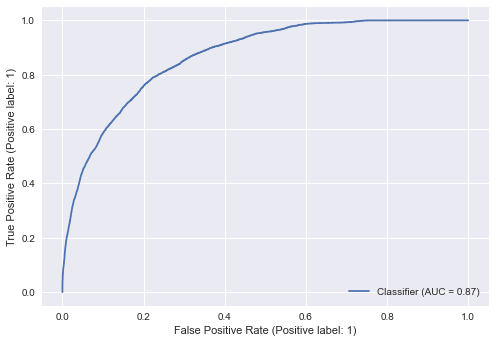

In [12]:
# prediction
y_train_pred = model.predict(X_train_log_scaled)
y_test_pred = model.predict(X_test_log_scaled)

# evaluate metrics
show_metrics(y_train, y_train_pred.round(), y_test, y_test_pred.round())
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

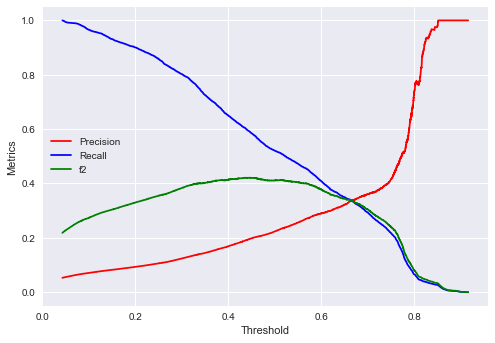

Max f2: 42.143 %; Threshold: 0.4366382360458374
Recall: 60.44 %
Precision: 19.062 %


In [13]:
show_threshold_tuning(y_test, y_test_pred)

# Stacking

Function for creating an ANN model:

In [14]:
#def create_ann_model():
def create_ann_model(n_feature): # n_feature = X_train.shape[1]

    # initiate the instance
    model = Sequential()

    # layers
    #model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu', input_dim=n_feature))
    model.add(Dropout(0.2))
    model.add(Dense(units = 30, kernel_initializer = 'uniform', activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

    # tuning optimizer (adam is the best)
    #optz = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.0, nesterov = False)
    #optz = tf.keras.optimizers.Adam(learning_rate = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)
    #optz = tf.keras.optimizers.Adamax(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999) # gives error during fit
    #optz = tf.keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)

    # compiling the ANN
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['Recall', 'Precision'])
    
    return model


Wrapping ANN with KerasClassifier:

In [15]:
ann_classifier = KerasClassifier(build_fn=lambda: create_ann_model(n_feature = X_train.shape[1]), epochs=50, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)
#ann_classifier = KerasClassifier(build_fn=create_ann_model, input_dim=X_train_log_scaled.shape[1] ,epochs=50, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)
ann_classifier._estimator_type = "classifier"


/var/folders/4f/mz1b5sg57p7324fdvfrshs1c0000gn/T/ipykernel_3585/3482773038.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ann_classifier = KerasClassifier(build_fn=lambda: create_ann_model(n_feature = X_train.shape[1]), epochs=50, batch_size= 40000, class_weight={0 : 1.0, 1 : 10.0}, verbose=2)


Construct weak estimators:

In [16]:
estimators = [
    ('xgb', XGBClassifier(  disable_default_eval_metric=True,
                        validate_parameters=True,
                        objective="binary:logistic",
                        #eval_metric=xgb_scorer, # Evaluation metric, can use our xgb_scorer
                        scale_pos_weight=len(y_train)/y_train.sum(), # ratio of number of negative class to the positive class
                        colsample_bytree=0.4, # 1, Number of features used by tree, lower to regularize
                        subsample=0.3, # 1, ratio of the training instances used, lower to regularize
                        eta=0.005, # 0.3, learning rate, lower values to regularize
                        gamma=1, # 0, regularization parameter, higher to regularize
                        max_depth=6, # 6, maximum tree depth
                        n_estimators=50 , # 100, number of trees to grow
                        min_child_weight=2 , # 1, minimum sum of instance weight needed in a leaf, higher to regularize
                        reg_lambda=0.7, # 1, L2 regularization
                        reg_alpha=1, # 0, L1 regularization
                        #early_stopping_rounds = 5, #100
                        use_label_encoder=False,
                        )),
    ('nb', GaussianNB()),
    ('nn', ann_classifier),
]

#clf = StackingClassifier(estimators = estimators, final_estimator=LogisticRegression(), n_jobs=-1, verbose=0)
clf = StackingClassifier(estimators = estimators, final_estimator=GaussianNB(), n_jobs=-1, verbose=0)

In [17]:
clf.fit(X_train_log_scaled, y_train)



2022-03-28 09:29:38.210996: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 09:29:38.211344: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-28 09:29:38.478501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-03-28 09:29:39.133296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 - 2s - loss: 0.9457 - recall: 0.0152 - precision: 0.0372 - 2s/epoch - 215ms/step
Epoch 2/50
9/9 - 1s - loss: 0.9399 - recall: 0.0000e+00 - precision: 0.0000e+00 - 604ms/epoch - 67ms/step
Epoch 3/50
9/9 - 1s - loss: 0.9302 - recall: 0.0000e+00 - precision: 0.0000e+00 - 594ms/epoch - 66ms/step
Epoch 4/50
9/9 - 0s - loss: 0.9137 - recall: 0.0000e+00 - precision: 0.0000e+00 - 466ms/epoch - 52ms/step
Epoch 5/50
9/9 - 0s - loss: 0.8881 - recall: 0.0000e+00 - precision: 0.0000e+00 - 422ms/epoch - 47ms/step
Epoch 6/50
9/9 - 0s - loss: 0.8554 - recall: 0.0000e+00 - precision: 0.0000e+00 - 362ms/epoch - 40ms/step
Epoch 7/50
9/9 - 0s - loss: 0.8249 - recall: 4.5582e-04 - precision: 0.8571 - 419ms/epoch - 47ms/step
Epoch 8/50
9/9 - 0s - loss: 0.8034 - recall: 0.0065 - precision: 0.5409 - 380ms/epoch - 42ms/step
Epoch 9/50
9/9 - 0s - loss: 0.7828 - recall: 0.0668 - precision: 0.3893 - 367ms/epoch - 41ms/step
Epoch 10/50
9/9 - 0s - loss: 0.7617 - recall: 0.1582 - precision: 0.3321 - 370ms/epoch 

2022-03-28 09:30:02.279889: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-03-28 09:30:12.324373: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 09:30:12.324815: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-03-28 09:30:14.371402: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50
Epoch 1/50


2022-03-28 09:30:19.268368: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:30:19.297625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:30:19.332345: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:30:19.351538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:30:19.375831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


7/7 - 11s - loss: 0.9462 - recall: 0.1707 - precision: 0.0439 - 11s/epoch - 2s/step
7/7 - 11s - loss: 0.9462 - recall: 0.1711 - precision: 0.0440 - 11s/epoch - 2s/step
7/7 - 11s - loss: 0.9462 - recall: 0.1709 - precision: 0.0440 - 11s/epoch - 2s/step
7/7 - 11s - loss: 0.9462 - recall: 0.1685 - precision: 0.0436 - 11s/epoch - 2s/step
7/7 - 11s - loss: 0.9462 - recall: 0.1752 - precision: 0.0449 - 11s/epoch - 2s/step
Epoch 2/50
Epoch 2/50
Epoch 2/50
Epoch 2/50
Epoch 2/50
7/7 - 8s - loss: 0.9419 - recall: 0.0000e+00 - precision: 0.0000e+00 - 8s/epoch - 1s/step
7/7 - 8s - loss: 0.9418 - recall: 0.0000e+00 - precision: 0.0000e+00 - 8s/epoch - 1s/step
7/7 - 8s - loss: 0.9419 - recall: 0.0000e+00 - precision: 0.0000e+00 - 8s/epoch - 1s/step
7/7 - 8s - loss: 0.9418 - recall: 0.0000e+00 - precision: 0.0000e+00 - 8s/epoch - 1s/step
7/7 - 8s - loss: 0.9419 - recall: 0.0000e+00 - precision: 0.0000e+00 - 8s/epoch - 1s/step
Epoch 3/50
Epoch 3/50
Epoch 3/50
Epoch 3/50
Epoch 3/50
7/7 - 5s - loss: 0.9

2022-03-28 09:32:23.777512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:32:23.778024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:32:23.779685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:32:23.782378: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-28 09:32:23.783927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.4,
                                              disable_default_eval_metric=True,
                                              enable_categorical=False,
                                              eta=0.005, gamma=1, gpu_id=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None,
                                              max_delta_step=None, max_depth=6,
                                              min_child_weig...
                                              n_estimators=50, n_jobs=None,
                

In [18]:
# prediction
y_train_pred = clf.predict_proba(X_train_log_scaled)[:,1]
y_test_pred = clf.predict_proba(X_test_log_scaled)[:,1]

2022-03-28 09:32:32.430576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


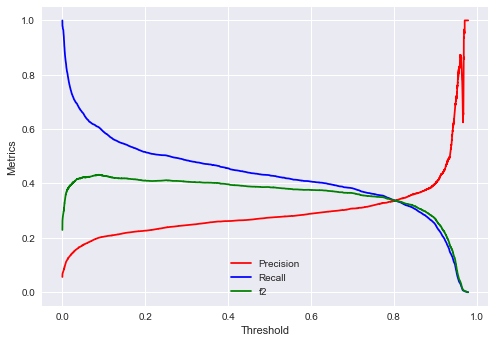

Max f2: 43.207 %; Threshold: 0.08852330452411908
Recall: 60.651 %
Precision: 20.092 %


In [19]:
show_threshold_tuning(y_test, y_test_pred)

# For train data:
  f2-score  : 42.081 %
  precision : 18.991 %
  recall    : 60.457 %
  accuracy  : 87.873 %
# For test data:
  f2-score  : 42.178 %
  precision : 20.945 %
  recall    : 56.496 %
  accuracy  : 89.594 %


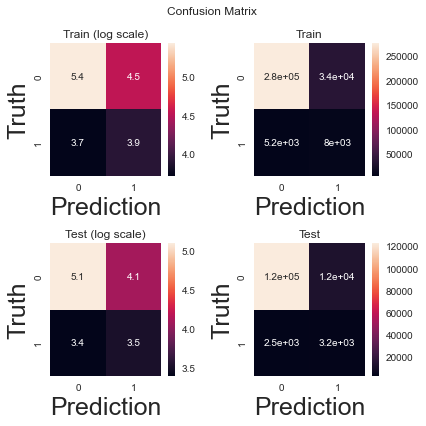

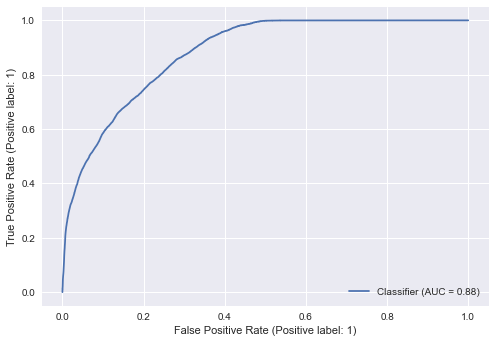

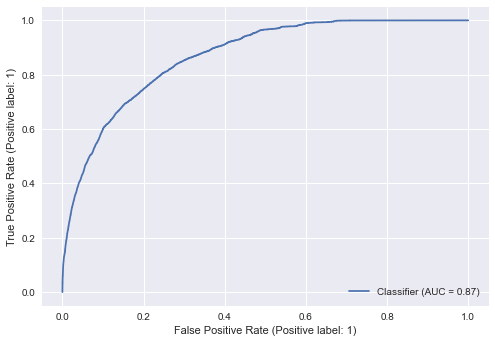

In [20]:
th = 0.12132
#th = 0.5
def binary_out(y, th=0.5):
    return np.array([ 1 if i >= th else 0 for i in y])

show_metrics(y_train, binary_out(y_train_pred, th=th), y_test, binary_out(y_test_pred, th=th))
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

# Save to Pickle

In [21]:
filename = 'models/ann_model.bin'
with open(filename, 'wb') as file_out:
    pickle.dump(model, file_out)

FileNotFoundError: [Errno 2] No such file or directory: 'models/ann_model.bin'

In [ ]:
loaded_model = pickle.load(open(filename, 'rb'))


2022-03-23 14:14:21.415634: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


# For train data:
  f2-score  : 40.778 %
  precision : 21.981 %
  recall    : 51.865 %
  accuracy  : 90.531 %
# For test data:
  f2-score  : 40.246 %
  precision : 24.965 %
  recall    : 47.518 %
  accuracy  : 92.084 %


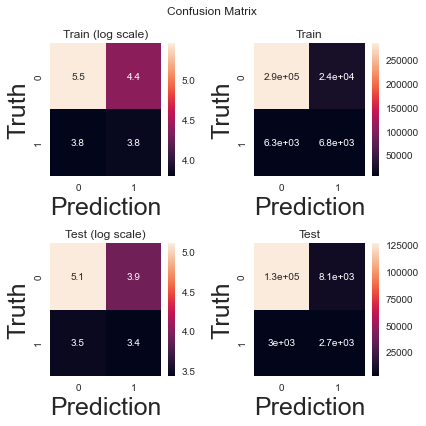

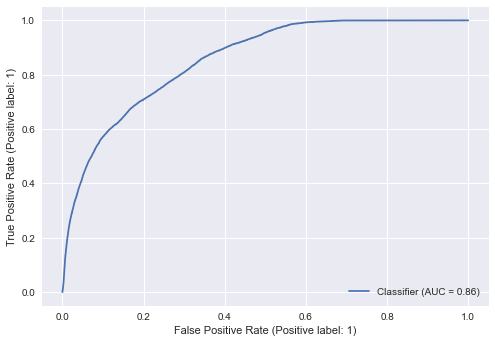

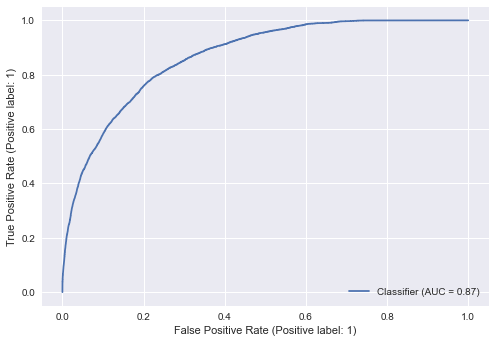

In [ ]:
# prediction
y_train_pred = loaded_model.predict(X_train_log_scaled)
y_test_pred = loaded_model.predict(X_test_log_scaled)

# evaluate metrics
show_metrics(y_train, y_train_pred.round(), y_test, y_test_pred.round())
show_roc_curve(y_train, y_train_pred, y_test, y_test_pred)